## Setup

In [1]:
  !curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Colab Notebooks/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
!ls "gdrive/My Drive/Colab Notebooks/data/poolsbinary/train/"

nopool	pool


In [0]:
import fastai
from fastai.text import *

In [6]:
print(fastai.__version__)

1.0.60


In [0]:
from sklearn.model_selection import train_test_split

In [0]:
import random
seed = random.seed(47)

In [0]:
 def random_seed(seed_value, use_cuda):
    import random 
    random.seed(seed_value) # Python
    import numpy as np
    np.random.seed(seed_value) # cpu vars
    import torch
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

## Looking at the data

In [11]:
path = 'gdrive/My Drive/Colab Notebooks/nlp_author_case/data/1_interim/'
df = pd.read_csv('gdrive/My Drive/Colab Notebooks/nlp_author_case/data/1_interim/training.csv')
df.head()

,id,text,author
0,1,Idris was well content with this resolve of mi...,MWS
1,2,"I was faint, even fainter than the hateful mod...",HPL
2,3,"Above all, I burn to know the incidents of you...",EAP
3,4,"He might see, perhaps, one or two points with ...",EAP
4,5,All obeyed the Lord Protector of dying England...,MWS


In [12]:
df['is_valid'] = False
df = df.loc[:,['author','text','is_valid']]
df = df.rename(columns={"author": "label"})
df.head()

,label,text,is_valid
0,MWS,Idris was well content with this resolve of mi...,False
1,HPL,"I was faint, even fainter than the hateful mod...",False
2,EAP,"Above all, I burn to know the incidents of you...",False
3,EAP,"He might see, perhaps, one or two points with ...",False
4,MWS,All obeyed the Lord Protector of dying England...,False


In [13]:
df_trn, df_val = train_test_split(df, stratify = df['label'], test_size = 0.2, random_state=seed)
df_trn.shape, df_val.shape

((15661, 3), (3916, 3))

In [14]:
random_seed(42,True)
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "",num_workers=0)
random_seed(42, True)
# Classifier model data
data_clas = TextClasDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "", vocab=data_lm.train_ds.vocab, bs=32,num_workers=0)

In [0]:
data_clas.show_batch()

text,target
xxbos xxmaj diotima approached the fountain seated herself on a mossy mound near it and her disciples placed themselves on the grass near her xxmaj without noticing me who sat close under her she continued her discourse addressing as it happened one or other of her listeners but before i attempt to repeat her words i will describe the chief of these whom she appeared to wish principally to impress,MWS
"xxbos xxmaj mus go in to night , you know else there 'll be the d l to pay , and ' ' xxmaj and not a bit of pitch hot , ' interrupted the foreman , with a deep sigh , and an emphasis on the ' bit . ' ' xxmaj is it a long paragraph , xxmaj bob ? ' ' xxmaj should n't call it a",EAP
"xxbos xxmaj ye who are linked by the affectionate ties of nature , companions , friends , lovers fathers , who toil with joy for their offspring ; women , who while gazing on the living forms of their children , forget the pains of xxunk ; children , who neither toil nor xxunk , but love and are loved "" xxmaj oh , that death and sickness were banished",MWS
"xxbos i had reached the conclusion , it will be remembered , that the extra baggage of my friend , the artist , would prove to be pictures , or at least a picture ; for i knew he had been for several weeks in conference with xxmaj nicolino : and now here was a box , which , from its shape , could possibly contain nothing in the world",EAP
"xxbos xxmaj then , as if pursued by an enemy , as if wings had been at her feet , she flew to her own apartment , she dismissed her attendants , she locked the doors , she threw herself wildly on the floor , she bit her lips even to blood to suppress her shrieks , and lay long a prey to the vulture of despair , striving not",MWS


In [0]:
random_seed(42, True)
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-02
Min loss divided by 10: 1.74E-02


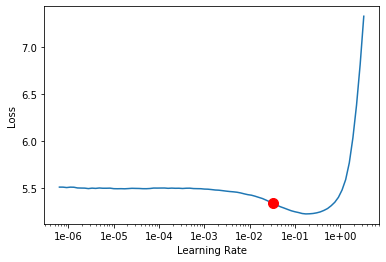

In [17]:
random_seed(42, True)
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [18]:
random_seed(42, True)
learn.fit_one_cycle(2, min_grad_lr)

epoch,train_loss,valid_loss,accuracy,time
0,4.580025,4.294693,0.282064,00:28
1,3.914768,4.171647,0.291021,00:30


In [19]:
random_seed(42, True)
# unfreezing weights and training the rest of the NN
learn.unfreeze()
learn.fit_one_cycle(2, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.417587,4.168099,0.292209,00:32
1,3.244300,4.193246,0.292620,00:31


In [20]:
learn.predict("How do", n_words=10)

'How do this suffice ? \n  xxbos As night flame fell'

In [21]:
random_seed(42, True)
# unfreezing weights and training the rest of the NN
learn.unfreeze()
learn.fit_one_cycle(2, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.180943,4.199069,0.292403,00:31
1,3.018154,4.244399,0.290812,00:32


In [0]:
learn.save_encoder('ft_enc_v6')

## Train Classifier

In [0]:
random_seed(42, True)
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('ft_enc_v6')

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.45E-03
Min loss divided by 10: 2.09E-02


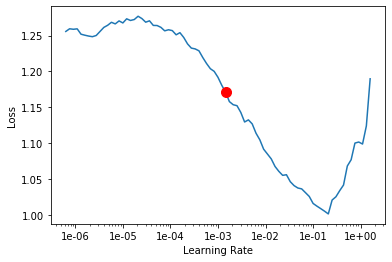

In [24]:
random_seed(42, True)
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [25]:
random_seed(42, True)
learn.fit_one_cycle(2, min_grad_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.739434,0.625672,0.740296,00:38
1,0.678244,0.612799,0.751532,00:36


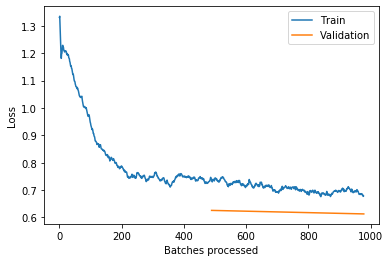

In [26]:
learn.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.74E-04


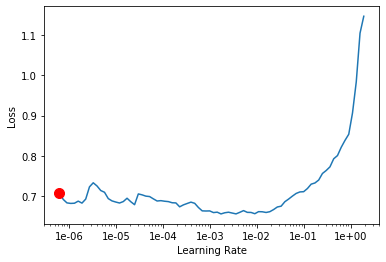

In [27]:
random_seed(42, True)
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [28]:
learn.freeze_to(-2)
random_seed(42, True)
learn.fit_one_cycle(4, slice(1e-5, 1e-1), moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time
0,0.776026,0.668400,0.717058,00:38
1,0.661920,0.551345,0.774770,00:36
2,0.582682,0.483201,0.810776,00:34
3,0.506563,0.446213,0.817926,00:35


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.91E-03


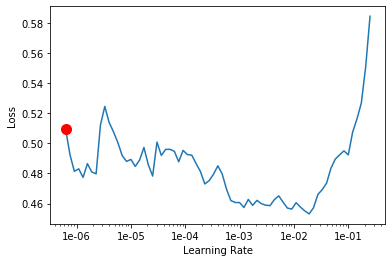

In [29]:
random_seed(42, True)
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [30]:
learn.unfreeze()
random_seed(42, True)
learn.fit_one_cycle(4, slice(2e-3/100, 2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.398566,0.434845,0.821246,00:41
1,0.222324,0.430681,0.832993,00:39
2,0.183848,0.438466,0.838100,00:37
3,0.374204,0.429198,0.838100,00:38


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-06
Min loss divided by 10: 6.31E-08


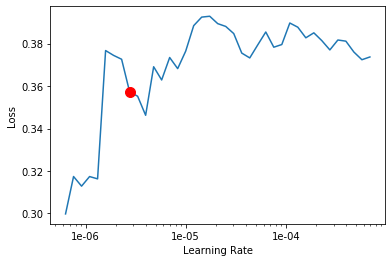

In [31]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [32]:
learn.unfreeze()
random_seed(42, True)
learn.fit_one_cycle(5, slice(2e-6/100, 2e-6), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.079036,0.428881,0.839122,00:41
1,0.036086,0.425694,0.838100,00:39
2,0.065576,0.433161,0.836823,00:37
3,0.368419,0.429839,0.838611,00:39
4,0.381187,0.442048,0.837845,00:39


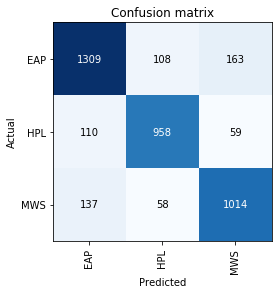

In [33]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
interp.plot_confusion_matrix()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-06
Min loss divided by 10: 1.74E-04


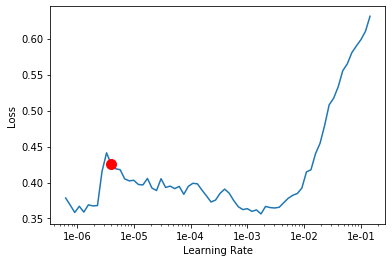

In [34]:
random_seed(42, True)
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [35]:
learn.predict("Idris was well content with this resolve")

(Category MWS, tensor(2), tensor([2.5048e-08, 2.6612e-06, 1.0000e+00]))

In [36]:
learn.unfreeze()
random_seed(42, True)
learn.fit_one_cycle(8, slice(2e-6, 2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.073972,0.444633,0.843207,00:41
1,0.017408,0.555859,0.839122,00:40
2,0.039137,0.682139,0.839888,00:37
3,0.405507,0.466749,0.839888,00:39
4,0.338739,0.420940,0.841931,00:39
5,0.327082,0.398963,0.846527,00:37
6,0.319880,0.399288,0.844995,00:39
7,0.327726,0.399004,0.847549,00:39


In [39]:
def make_submission():
  #Submission df
  submission_df = pd.read_csv('gdrive/My Drive/Colab Notebooks/nlp_author_case/data/0_raw/test.csv')
  learn.data.add_test(submission_df['text'])
  prob_preds = learn.get_preds(ds_type=DatasetType.Test, ordered=True)
  df = pd.DataFrame({'id': submission_df['id'],
                    'EAP':prob_preds[0].numpy()[:,0],
                    'HPL':prob_preds[0].numpy()[:,1],
                    'MWS':prob_preds[0].numpy()[:,2]})
  df.to_csv('gdrive/My Drive/Colab Notebooks/nlp_author_case/data/2_processed/submission.csv', index=False)
  return 'Done'

make_submission()

'Done'

In [0]:
learn.export('gdrive/My Drive/Colab Notebooks/nlp_author_case/models/export_847_v7.pkl')

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 8.32E-05


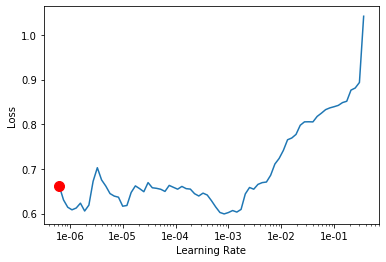

In [43]:
random_seed(42, True)
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [44]:
learn.unfreeze()
random_seed(42, True)
learn.fit_one_cycle(3, slice(2e-4, 2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.395676,0.428792,0.830184,00:43
1,0.223701,0.379128,0.852400,00:41
2,0.189067,0.382202,0.862615,00:39


In [46]:
make_submission()

'Done'

In [49]:
learn.unfreeze()
random_seed(42, True)
learn.fit_one_cycle(3, slice(2e-4, 2e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.288352,0.534062,0.819459,00:42
1,0.203375,0.468668,0.837079,00:41
2,0.166658,0.444569,0.866445,00:39


In [50]:
make_submission()

'Done'

In [0]:
learn.export('gdrive/My Drive/Colab Notebooks/nlp_author_case/models/export_867_v7.pkl')

In [52]:
random_seed(42, True)
learn.fit_one_cycle(2, slice(2e-6, 2e-5), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.040317,0.369149,0.868488,00:41
1,0.034934,0.381699,0.864402,00:41
